# Matrix completion and recommender systems


[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:

- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.


In [2]:
dataset = pd.read_csv("movielens.csv", sep="\t", header=None)
dataset.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


How many movies? How many people? How many ratings?


In [3]:
n_movies = dataset[1].unique().shape[0]
n_people = dataset[0].unique().shape[0]
n_ratings = len(dataset)

f"Number of movies: {n_movies}, number of people: {n_people}, number of ratings: {n_ratings}"

'Number of movies: 1682, number of people: 943, number of ratings: 100000'

Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).


In [4]:
rating_values_arr = dataset.values
rating_values_arr

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       ...,
       [      276,      1090,         1, 874795795],
       [       13,       225,         2, 882399156],
       [       12,       203,         3, 879959583]])

In [5]:
np.random.shuffle(rating_values_arr)
rating_values_arr

array([[      639,       135,         4, 891239239],
       [      183,        88,         3, 891466760],
       [      387,       559,         3, 886481737],
       ...,
       [      342,       208,         4, 874984430],
       [      125,        28,         4, 879454385],
       [      305,       686,         3, 886324330]])

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.


In [6]:
train_arr = rating_values_arr[:80000]
test_arr = rating_values_arr[80000:]
train_arr.shape, test_arr.shape

((80000, 4), (20000, 4))

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:

$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$


In [7]:
matrix = np.zeros((n_people, n_movies))
matrix[:] = np.nan
for person_id, movie_id, rating, _ in train_arr:
    matrix[person_id - 1, movie_id - 1] = rating

matrix.shape

(943, 1682)

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:

$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$

where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):

$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):

$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$

where

$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$


In [10]:
r_pred = np.zeros((n_people, n_movies))

for i in range(n_people):
    avg_rating_user = np.nanmean(matrix[i, :])
    for j in range(n_movies):
        r_pred[i, j] = avg_rating_user if np.isnan(matrix[i, j]) else matrix[i, j]

r_pred.shape

(943, 1682)

In [11]:
test_values = test_arr[:, 2]
r_pred_values = np.array(
    [r_pred[test_arr[i][0] - 1][test_arr[i][1] - 1] for i in range(len(test_arr))]
)

In [12]:
rmse = np.sqrt(1 / len(test_arr) * sum((test_values - r_pred_values) ** 2))

rmse

np.float64(1.041257362136144)

In [13]:
pearsonr(test_values, r_pred_values)

PearsonRResult(statistic=np.float64(0.37519165386827047), pvalue=np.float64(0.0))

# Singular value truncation (SVT) based recommender system


Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.


In [14]:
max_it = 100
rmses = []
pearsons = []
threshold = 150
tolerance = 1e-6

x_hat = np.zeros((n_people, n_movies))
for person_id, movie_id, rating, _ in train_arr:
    x_hat[person_id - 1, movie_id - 1] = rating

for k in range(max_it):
    x_old = x_hat.copy()
    U, s, VT = np.linalg.svd(x_hat, full_matrices=False)
    sigma_hat = np.array(
        [s_val if s_val > threshold else 0 for s_val in s]
    )  # truncation step
    x_hat = U @ np.diag(sigma_hat) @ VT
    for person_id, movie_id, rating, _ in train_arr:
        x_hat[person_id - 1, movie_id - 1] = rating

    x_pred_values = np.array(
        [x_hat[test_arr[i][0] - 1][test_arr[i][1] - 1] for i in range(len(test_arr))]
    )
    rmse = np.sqrt(1 / len(test_arr) * sum((test_values - x_pred_values) ** 2))
    rmses.append(rmse)
    pearson = pearsonr(test_values, x_pred_values)
    pearsons.append(pearson[0])

    error = np.linalg.norm(x_hat - x_old)
    print(
        f"Iteration {k + 1}, with error={error:2e}, rmse={rmse:2e}, pearson={pearson[0]:2e}"
    )
    if error < tolerance:
        break

Iteration 1, with error=4.141545e+02, rmse=2.765605e+00, pearson=2.795211e-01
Iteration 2, with error=2.640844e+02, rmse=2.337283e+00, pearson=3.042059e-01
Iteration 3, with error=1.955328e+02, rmse=2.084401e+00, pearson=3.238772e-01
Iteration 4, with error=1.559171e+02, rmse=1.912865e+00, pearson=3.399404e-01
Iteration 5, with error=1.297783e+02, rmse=1.787211e+00, pearson=3.533781e-01
Iteration 6, with error=1.111150e+02, rmse=1.690570e+00, pearson=3.648609e-01
Iteration 7, with error=9.708318e+01, rmse=1.613661e+00, pearson=3.748497e-01
Iteration 8, with error=8.614093e+01, rmse=1.550867e+00, pearson=3.836670e-01
Iteration 9, with error=7.737023e+01, rmse=1.498559e+00, pearson=3.915439e-01
Iteration 10, with error=7.018652e+01, rmse=1.454270e+00, pearson=3.986499e-01
Iteration 11, with error=6.419831e+01, rmse=1.416266e+00, pearson=4.051129e-01
Iteration 12, with error=5.913289e+01, rmse=1.383281e+00, pearson=4.110308e-01
Iteration 13, with error=5.479425e+01, rmse=1.354376e+00, pea

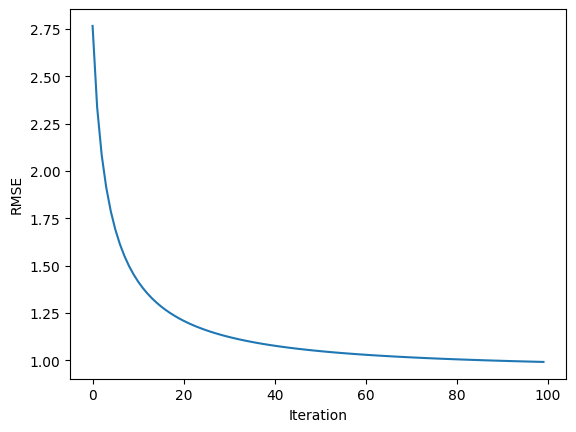

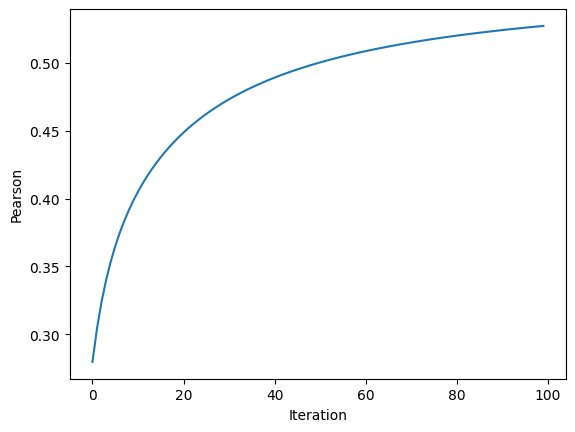

In [15]:
plt.plot(rmses)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

plt.plot(pearsons)
plt.xlabel("Iteration")
plt.ylabel("Pearson")
plt.show()